In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from rtlsdr import RtlSdr
from skyfield.api import load, wgs84, Star
from skyfield.data import hipparcos
import threading
import time
import queue

In [24]:
LAT = 34.05  
LON = -118.25
FM_FREQ = 98.5e6
GAIN = 40
SAMPLE_RATE = 2.048e6

In [25]:
data_queue = queue.Queue()
plot_data = {
    "stars_theta": [], "stars_r": [], "stars_size": [],
    "sats_theta": [], "sats_r": [], "sat_names": []
}
is_running = True

In [26]:
def update_physics():
    print("Connecting to physics servers...")
    ts = load.timescale()
    
    # 1. ONLINE LOAD: Planetary Ephemeris
    eph = load('de421.bsp')
    earth = eph['earth']
    
    # 2. ONLINE LOAD: Star Catalog (Hipparcos)
    print("Downloading Star Catalog...")
    with load.open(hipparcos.URL) as f:
        df = hipparcos.load_dataframe(f)
    
    # Filter for bright stars (Mag < 3.0) for performance
    bright_df = df[df['magnitude'] <= 3.0]
    star_objects = Star.from_dataframe(bright_df)
    
    # 3. ONLINE LOAD: Satellite TLEs
    print("Downloading Satellite Orbits...")
    weather_sats = load.tle_file('https://celestrak.org/NORAD/elements/weather.txt')
    station_sats = load.tle_file('https://celestrak.org/NORAD/elements/stations.txt')
    sats = weather_sats + station_sats
    
    my_loc = earth + wgs84.latlon(LAT, LON)
    print("Physics Engine Running.")

    while is_running:
        t = ts.now()
        
        # --- A. STARS ---
        astrometric = my_loc.at(t).observe(star_objects)
        alt, az, _ = astrometric.apparent().altaz()
        
        visible_mask = alt.degrees > 0
        s_theta = np.radians(az.degrees[visible_mask])
        s_r = 90.0 - alt.degrees[visible_mask] # Map 90 deg alt to 0 radius (center)
        # Size logic: Lower mag = Bigger dot
        s_size = (3.5 - bright_df['magnitude'][visible_mask]) * 15
        
        # --- B. SATELLITES ---
        sat_theta = []
        sat_r = []
        
        for sat in sats:
            diff = sat - my_loc
            topocentric = diff.at(t)
            alt_s, az_s, _ = topocentric.altaz()
            
            if alt_s.degrees > 0:
                sat_theta.append(np.radians(az_s.degrees))
                sat_r.append(90 - alt_s.degrees)
        
        # Update Globals
        plot_data["stars_theta"] = s_theta
        plot_data["stars_r"] = s_r
        plot_data["stars_size"] = s_size
        plot_data["sats_theta"] = sat_theta
        plot_data["sats_r"] = sat_r
        
        time.sleep(1.0) # Update once per second

In [27]:
def monitor_radio():
    sdr = RtlSdr()
    sdr.sample_rate = 2.048e6
    sdr.center_freq = FM_FREQ
    sdr.gain = GAIN
    print(f"Radio listening on {FM_FREQ/1e6} MHz")

    noise_floor = -50
    
    while is_running:
        samples = sdr.read_samples(256*1024)
        power = np.abs(np.fft.fft(samples))**2
        power_db = 10 * np.log10(power + 1e-9)
        peak = np.max(power_db)
        
        noise_floor = 0.95 * noise_floor + 0.05 * np.mean(power_db)
        
        # Trigger Threshold: 8dB above floor
        if peak > (noise_floor + 8):
            data_queue.put("FLASH")

In [ ]:
def run_dashboard():
    fig = plt.figure(figsize=(10, 10), facecolor='black')
    ax = fig.add_subplot(111, projection='polar')
    ax.set_facecolor('black')
    
    # Radar Styling
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1) # Clockwise
    ax.set_rticks([30, 60, 90])
    ax.set_yticklabels([])
    ax.grid(color='#444444', alpha=0.3)
    
    # PLOT OBJECTS
    # 1. Stars (White)
    star_dots = ax.scatter([], [], c='white', alpha=0.75, s=[], edgecolors='none')
    # 2. Satellites (Cyan)
    sat_dots, = ax.plot([], [], 'co', markersize=8, markeredgecolor='blue')
    # 3. Meteor Flash (Red Ring)
    pulse, = ax.plot([], [], 'r-', linewidth=4, alpha=0)

    def animate(frame):
        # Draw Stars
        if len(plot_data["stars_theta"]) > 0:
            offsets = np.c_[plot_data["stars_theta"], plot_data["stars_r"]]
            star_dots.set_offsets(offsets)
            star_dots.set_sizes(plot_data["stars_size"])
        
        # Draw Satellites
        sat_dots.set_data(plot_data["sats_theta"], plot_data["sats_r"])
        
        # Handle Meteor Flash
        try:
            if data_queue.get_nowait() == "FLASH":
                pulse.set_data(np.linspace(0, 2*np.pi, 100), [90]*100)
                pulse.set_alpha(1.0)
        except queue.Empty:
            curr = pulse.get_alpha()
            if curr > 0: pulse.set_alpha(curr - 0.1)
            
        return star_dots, sat_dots, pulse

    # Start Threads
    t1 = threading.Thread(target=update_physics)
    t2 = threading.Thread(target=monitor_radio)
    t1.start()
    t2.start()
    
    ani = FuncAnimation(fig, animate, interval=200)
    plt.show()

    # Cleanup on close
    global is_running
    is_running = False
    t1.join()
    t2.join()

Connecting to physics servers...


C:\Users\jlama\AppData\Local\Temp\ipykernel_14100\2020239398.py:48: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, animate, interval=200)


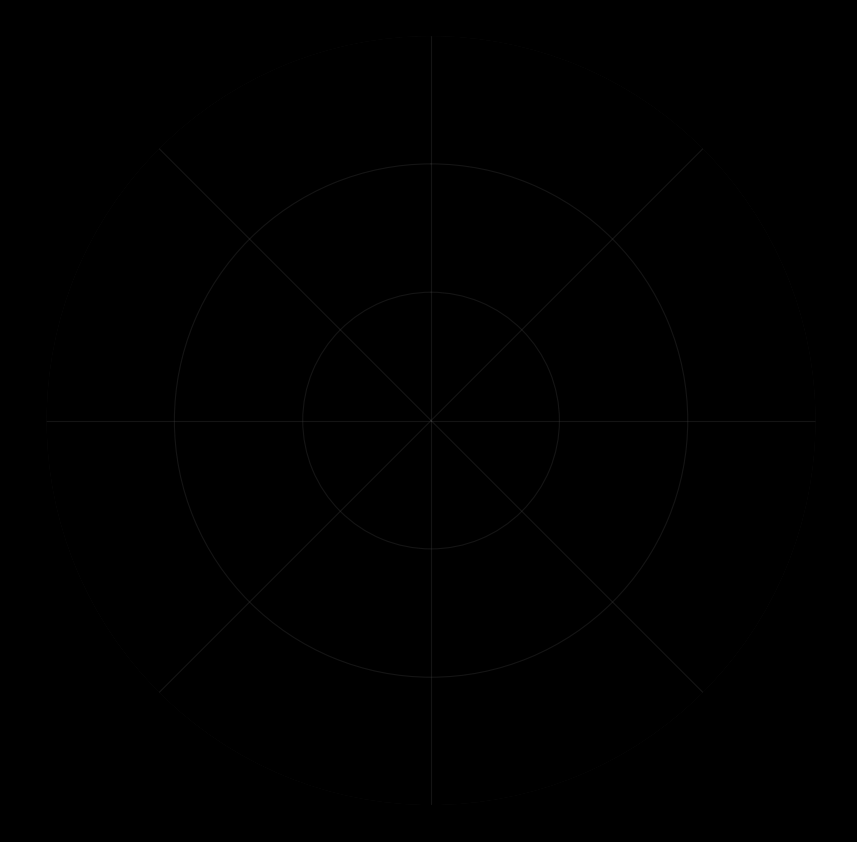

Physics Engine Running.
Radio listening on 98.5 MHz


c:\Users\jlama\Documents\sky-rtl-sdr\.venv\Lib\site-packages\matplotlib\animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [29]:
run_dashboard()